# Aprendizagem de máquina

### Anotações
- ω: varivel aleatoria
- P(ωk):probabilidade a priori de observar ωk
- p(x|ωj): funcao de densidade de probabilidade condicional de x dado que a classe é ωj
    - : p(x intersecção wj) / P(wj)
- P(ωj|x): probabilidade da classe ser ωj dado que observou-se x
    - : p(x|ωj)P(ωj)/p(x)

In [1]:
from math import ceil

import numpy as np
import pandas as pd
import itertools as it

# from scipy.stats import mode

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error

import scipy as sp
import scipy.stats as st

from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import colors

## Funções para os testes de Friedman e Nemenyi

In [2]:
def friedman_test(*args):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [sp.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/sp.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((sp.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    return iman_davenport, p_value, rankings_avg, rankings_cmp

def nemenyi_multitest(ranks):
    """
        Performs a Nemenyi post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of each pair of groups are different.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        Bonferroni-Dunn: O.J. Dunn, Multiple comparisons among means, Journal of the American Statistical Association 56 (1961) 52–64.
    """
    k = len(ranks)
    values = list(ranks.values())
#     print (ranks.keys())
    keys = list(ranks.keys())
    versus = list(it.combinations(range(k), 2))

    comparisons = [keys[vs[0]] + " vs " + keys[vs[1]] for vs in versus]
    z_values = [abs(values[vs[0]] - values[vs[1]]) for vs in versus]
    p_values = [2*(1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    m = int(k*(k-1)/2.)
    adj_p_values = [min(m*p_value,1) for p_value in p_values]
    
    return comparisons, z_values, p_values, adj_p_values


### Função para plotar os graficos de acuracias

In [3]:
def plot_accuracy(train, validation, all_data):
    
    fig, ax = plt.subplots()
    ax.plot(train, label='Treinamento')
    ax.plot(validation, label='Validação')
    ax.plot(all_data, label='Treinamento com toda a base de dados')
    ax.set(title='Acurácia do classificador', xlabel='Folds', ylabel='Acurácia')
    vals = ax.get_yticks()
    ax.set_yticklabels([('%.2f%%' % (x*100)) for x in vals])
    ax.legend()
    plt.show()

### Função para calcular o intervalo de confiânça

In [5]:
def confidence_interval(media, erro, tamanho_amostra, confianca = 1.96):
    
    """
    confiança
    1.64 (90%)
    1.96 (95%)
    2.33 (98%)
    2.58 (99%)
    """
    
#     err = confianca * pow((erro * (1 - erro))/tamanho_amostra, 0.5)
#     err = confianca*
#     print (err)
    return [media - err, media + err, err]

# confidence_interval(0.85,0.09,2000)

## Leitura da base de dados

A leitura da base de dados foi feita utilizando a biblioteca `pandas`.

In [6]:
data_set = pd.read_csv('segmentation2.csv', skiprows=[0,1,2]) # skiprows utilizado para pular as 3 primeiras linhas do aquivo


## Alterando o nome da clase de string para número

In [7]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == 'GRASS') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 1 if (x == 'PATH') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 2 if (x == 'WINDOW') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 3 if (x == 'CEMENT') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 4 if (x == 'FOLIAGE') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 5 if (x == 'SKY') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 6 if (x == 'BRICKFACE') else x)

## Normalização e tratamento de repetições

In [8]:
columns = data_set.columns.tolist()
data_set.drop_duplicates(subset=columns, keep='first', inplace=True)  # Remove exemplos repetidos da base de dados

## Sepando a base em Kfolds

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os kfolds

In [20]:
def separar_grupos(data_set):
    grass = data_set[data_set.CLASS == 0]
    path = data_set[data_set.CLASS == 1]
    window = data_set[data_set.CLASS == 2]
    cement = data_set[data_set.CLASS == 3]
    foliage = data_set[data_set.CLASS == 4]
    sky = data_set[data_set.CLASS == 5]
    brickface = data_set[data_set.CLASS == 6]
    
    return [grass, path, window, cement, foliage, sky, brickface]
    

Criando função para, dado a base de dados separada por classes, dividi-la em kfolds, sendo que em cada fold tenha exatamente a mesma quantidade de exemplos de cada classe

In [10]:
def dividir_em_kfolds(grupos, numfolds = 10):
    
    def split_list(grupo, quant):
        grupos = []
        incremento = int(len(grupo)/quant)
        for g in range(0,len(grupo), incremento):
            grupos.append(grupo[g:g + incremento])
        return grupos[:quant]
    
    tam_grupo = 0
    for i, grupo in enumerate(grupos):
        grupos[i] = split_list(grupo, numfolds)
        tam_grupo = max(tam_grupo, len(grupos[i][0]))
    
    for i, grupo in enumerate(grupos):
        for j, g in enumerate(grupos[i]):
            grupos[i][j] = grupos[i][j].iloc[:,:].values
            if len(grupos[i][j]) < tam_grupo:
                grupos[i][j] = np.concatenate((grupos[i][j],grupos[i][j]), axis=0)
            grupos[i][j] = grupos[i][j][:tam_grupo]
            
    folds = []
    for i in range(0, numfolds):
        fold = np.concatenate((grupos[0][i], grupos[1][i],grupos[2][i],grupos[3][i],grupos[4][i],grupos[5][i],grupos[6][i]), axis=0)
        np.random.shuffle(fold)
        folds.append(fold)
                
    return folds
# for i in dividir_em_kfolds(separar_grupos(data_set)):
#     print (len(i))

Criando a função de dado os kfolds retornar os conjuntos de trainamento e validação e a função de dado os kfolds retornar uma lista com k conjuntos, sendo que em cada conjunto tem um conjunto de treinamento e um conjunto de validação

In [11]:
def kfolds(folds, i, k = 10):
    v = i%k
#     t = (i + 1)%k
#     validation = folds.pop(max(v,t))
    validation = folds.pop(v)
#     test = folds.pop(min(v,t))
    train = folds[0]
    for fold in folds[1:]:
        train = np.concatenate((train, fold), axis=0)
    
    return (train, validation)

def split(data, k = 300):
    folds = []
    for i in range(0,k):
        folds.append(kfolds(data[:], i))
    return folds
# grupos = dividir_em_grupos([grass, path, window, cement, foliage, sky, brickface])

## Dividindo a base em duas views

- `shape_view` é uma view com as primeiras 9 variáveis da base de dados, ou seja, tem as colunas `REGION-CENTROID-COL, REGION-CENTROID-ROW, REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5, SHORT-LINE-DENSITY-2, VEDGE-MEAN, VEDGE-SD, HEDGE-MEAN, HEDGE-SD, CLASS`
- `rgb_view` é uma view com as 10 ultimas variáveis da base de dados, ou seja, tem as colunas `INTENSITY-MEAN, RAWRED-MEAN, RAWBLUE-MEAN, RAWGREEN-MEAN, EXRED-MEAN, EXBLUE-MEAN, EXGREEN-MEAN, VALUE-MEAN, SATURATION-MEAN, HUE-MEAN, CLASS`

In [12]:
columns = data_set.columns.tolist()
shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
data_view = data_set.reindex(columns=columns[1:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence


## Utilizando o classificador bayesiano para fazer a classificação dos dados

Utilizando as 19 colunas da base de dados.
- Teve uma taxa média de 76,1429% de acerto
- Desvio padrão de ± 7,4088%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 80.0964%
Intervalo de confiânça: ± 0.0429%, com 95% de confiança!

Validação Kfolds:
Media: 78.8296%
Intervalo de confiânça: ± 0.1796%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 79.6740%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


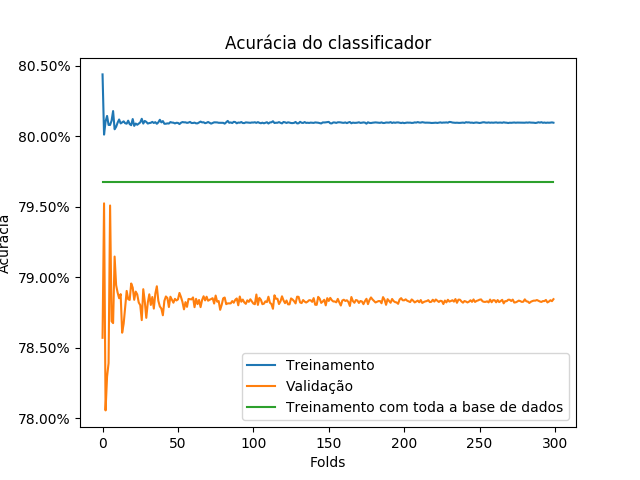

In [67]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0
# acuracia = []
for train, validation in kfolds.split(data_view.iloc[:,:-1].values, data_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()
    X_t = scaler.fit_transform(data_view.iloc[train,:-1].values)
    X_v = scaler.transform(data_view.iloc[validation,:-1].values)
    y_t = data_view.iloc[train,-1].values
    y_v = data_view.iloc[validation,-1].values
    gnb = GaussianNB(priors=priori)
    gnb.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = gnb.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = gnb.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    gnb.fit(X, y)
    pred = gnb.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )


    
print ()
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `shape_view` com as 9 primeiras colunas da base de dados.
- Teve uma taxa média de 45,8095% de acerto
- Desvio padrão de ± 3,2771%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 48.0915%
Intervalo de confiânça: ± 0.1443%, com 95% de confiança!

Validação Kfolds:
Media: 49.2984%
Intervalo de confiânça: ± 0.3192%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 48.5618%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


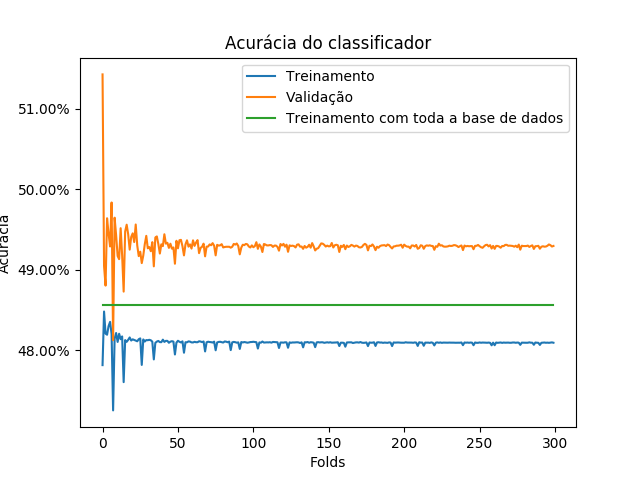

In [13]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

# folds = dividir_em_kfolds(separar_grupos(shape_view))
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(shape_view.iloc[:,:-1].values, shape_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()

    X_t = scaler.fit_transform(shape_view.iloc[train,:-1].values)
    X_v = scaler.transform(shape_view.iloc[validation,:-1].values)
    y_t = shape_view.iloc[train,-1].values
    y_v = shape_view.iloc[validation,-1].values
    gnb = GaussianNB(priors=priori)
    gnb.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = gnb.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = gnb.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    gnb.fit(X, y)
    pred = gnb.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

    
print ()    
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `rgb_view` com as 10 últimas colunas da base de dados.
- Taxa média de 73,8095% de acerto
- Desvio padrão de ± 8,0606, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 79.8076%
Intervalo de confiânça: ± 0.0242%, com 95% de confiança!

Validação Kfolds:
Media: 78.7064%
Intervalo de confiânça: ± 0.1429%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 79.9616%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


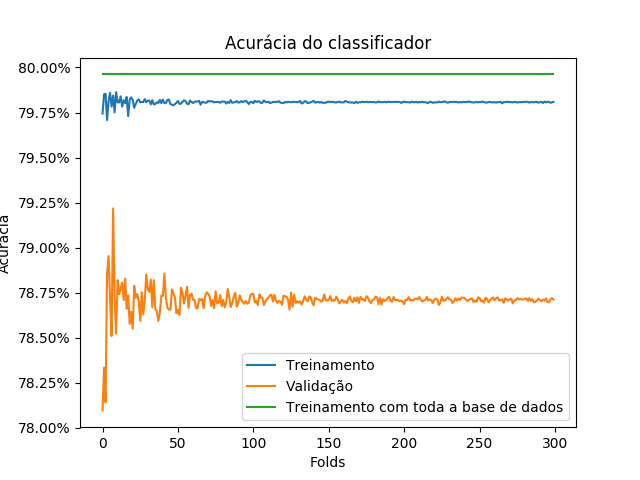

In [14]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

# folds = dividir_em_kfolds(separar_grupos(rgb_view))
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(rgb_view.iloc[:,:-1].values, rgb_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()

    X_t = scaler.fit_transform(rgb_view.iloc[train,:-1].values)
    X_v = scaler.transform(rgb_view.iloc[validation,:-1].values)
    y_t = rgb_view.iloc[train,-1].values
    y_v = rgb_view.iloc[validation,-1].values
    gnb = GaussianNB(priors=priori)
    gnb.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = gnb.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = gnb.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    gnb.fit(X, y)
    pred = gnb.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

    
print ()
friedman_gnb_rgb = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

## Utilizando o KNN para fazer a classificação dos dados

Utilizando as 19 colunas da base de dados.
- Foi testado valores para k entre 1 e 120
- O melhor resuldado se deu para k=1, que foi de 96,5441% de acerto
- Desvio padrão de ± 0,8676%, com o intervalo de confiança de 95%
- Para k=3, o classificador teve 95,9542% de acerto e desvio padrão de ± 0,9436%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 100.0000%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!

Validação Kfolds:
Media: 96.0810%
Intervalo de confiânça: ± 0.1813%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 100.0000%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


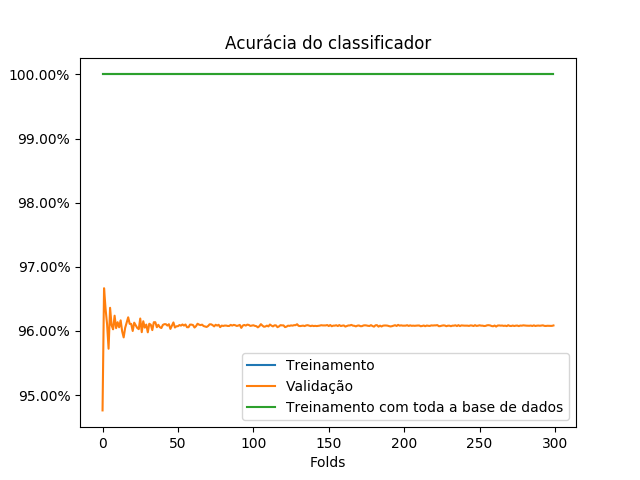

In [15]:
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(data_view.iloc[:,:-1].values, data_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()

    X_t = scaler.fit_transform(data_view.iloc[train,:-1].values)
    X_v = scaler.transform(data_view.iloc[validation,:-1].values)
    y_t = data_view.iloc[train,-1].values
    y_v = data_view.iloc[validation,-1].values

    knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    knn.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

    
print ()
friedman_knn_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `shape_view` com as 9 primeiras colunas da base de dados.
- Foi testado valores para k entre 1 e 120
- O melhor resuldado se deu para k=6, que foi de 67,5679% de acerto
- Desvio padrão de ± 1,9552%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 83.6193%
Intervalo de confiânça: ± 0.0288%, com 95% de confiança!

Validação Kfolds:
Media: 67.8888%
Intervalo de confiânça: ± 0.3773%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 84.0104%
Intervalo de confiânça: ± 0.0051%, com 95% de confiança!



<IPython.core.display.Javascript object>


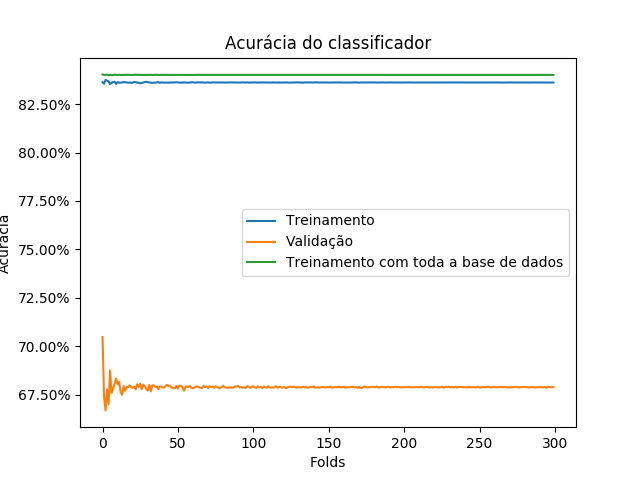

In [16]:
# folds = dividir_em_kfolds(separar_grupos(shape_view))

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(shape_view.iloc[:,:-1].values, shape_view.iloc[:,-1].values):

    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1

    scaler = StandardScaler()

    X_t = scaler.fit_transform(shape_view.iloc[train,:-1].values)
    X_v = scaler.transform(shape_view.iloc[validation,:-1].values)
    y_t = shape_view.iloc[train,-1].values
    y_v = shape_view.iloc[validation,-1].values

    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn.fit(X_t, y_t)

    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )

    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )

    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )


print ()

friedman_knn_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `rgb_view` com as 10 últimas colunas da base de dados.
- Foi testado valores para k entre 1 e 120
- O melhor resuldado se deu para k=3, que foi de 90,2915% de acerto
- Desvio padrão de ± 1,4367, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 94.6688%
Intervalo de confiânça: ± 0.0368%, com 95% de confiança!

Validação Kfolds:
Media: 89.9049%
Intervalo de confiânça: ± 0.1925%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 94.6766%
Intervalo de confiânça: ± 0.0197%, com 95% de confiança!



<IPython.core.display.Javascript object>


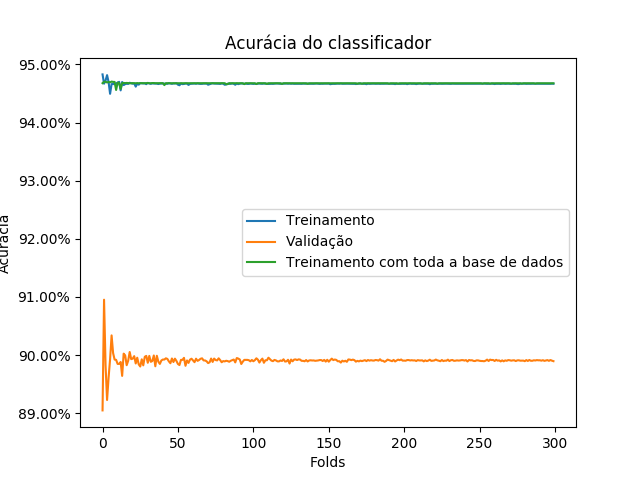

In [17]:
# folds = dividir_em_kfolds(separar_grupos(rgb_view))

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(rgb_view.iloc[:,:-1].values, rgb_view.iloc[:,-1].values):

    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1

    scaler = StandardScaler()

    X_t = scaler.fit_transform(rgb_view.iloc[train,:-1].values)
    X_v = scaler.transform(rgb_view.iloc[validation,:-1].values)
    y_t = rgb_view.iloc[train,-1].values
    y_v = rgb_view.iloc[validation,-1].values

    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn.fit(X_t, y_t)

    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )

    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )

    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )


print ()

friedman_knn_rgb = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Retirando apenas as colunas 3,4 e 5 o classificador teve uma melhora de 0,52% em relação quando estava com todas as colunas, tendo assim uma taxa de acerto de 96,62% para k=1 e 95,81% para k=3

99.67% [=================================================>]
Treinamento Kfolds:
Media: 98.5465%
Intervalo de confiânça: ± 0.0169%, com 95% de confiança!

Validação Kfolds:
Media: 96.4279%
Intervalo de confiânça: ± 0.1155%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 98.5783%
Intervalo de confiânça: ± 0.0053%, com 95% de confiança!



<IPython.core.display.Javascript object>


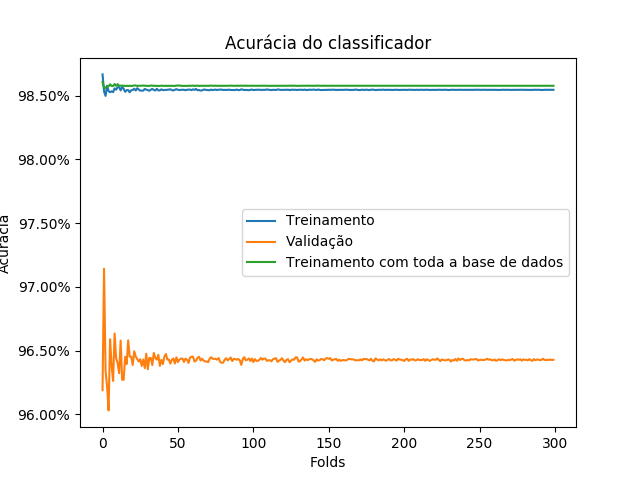

In [74]:
columns = data_set.columns.tolist()
data_set_mod = data_set.reindex(columns=columns[1:3] + columns[6:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(data_set_mod.iloc[:,:-1].values, data_set_mod.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    scaler = StandardScaler()

    X_t = scaler.fit_transform(data_set_mod.iloc[train,:-1].values)
    X_v = scaler.transform(data_set_mod.iloc[validation,:-1].values)
    y_t = data_set_mod.iloc[train,-1].values
    y_v = data_set_mod.iloc[validation,-1].values
    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

print ("")
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

In [65]:
# for i in range(0,20):
#     print 
from time import sleep
for i in range(0,95):
    print ("\r%.2f%% [%s]" % (i*100/95,'='*int(i/95) + '>' + '-'*int(49-i/95)), end='')
    sleep(0.1)

98.95% [>------------------------------------------------]

## Utilizando o voto majoritário para fazer a classificação dos dados

Para calcular o voto majoritário foi levado em consideração dois classificadores, o classificador bayesiano e o KNN, e para cada classificador foi utilizado duas views, a view `shape_view`e a `rgb_view`, assim totalizando 4 votos para cada caso de teste.

99.67% [=================================================>]
Treinamento Kfolds:
Media: 92.0259%
Intervalo de confiânça: ± 0.0275%, com 95% de confiança!

Validação Kfolds:
Media: 84.7724%
Intervalo de confiânça: ± 0.1332%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 92.1958%
Intervalo de confiânça: ± 0.0100%, com 95% de confiança!



<IPython.core.display.Javascript object>


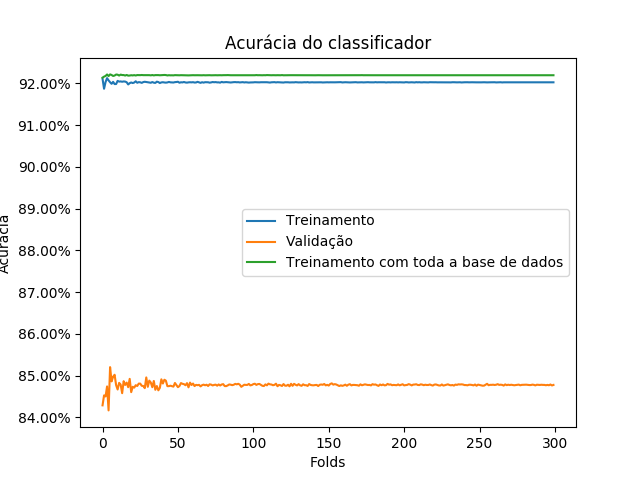

In [18]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(data_view.iloc[:,:-1].values, data_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()
    X_shape_t = scaler.fit_transform(data_view.iloc[train,0:9].values)
    X_shape_v = scaler.transform(data_view.iloc[validation,0:9].values)
    
    X_rgb_t = scaler.fit_transform(data_view.iloc[train,9:-1].values)
    X_rgb_v = scaler.transform(data_view.iloc[validation,9:-1].values)
    
    y_t = data_view.iloc[train,-1].values
    y_v = data_view.iloc[validation,-1].values
    
    knn_shape = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn_rgb = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    gnb_shape = GaussianNB(priors=priori)
    gnb_rgb = GaussianNB(priors=priori)
    
    
    knn_shape.fit(X_shape_t, y_t)
    knn_rgb.fit(X_rgb_t, y_t)
    gnb_shape.fit(X_shape_t, y_t)
    gnb_rgb.fit(X_rgb_t, y_t)
    
    #acuracia kfolds
    #validation
    pred_knn_shape = knn_shape.predict(X_shape_v)
    pred_knn_rgb = knn_rgb.predict(X_rgb_v)
    pred_gnb_shape = gnb_shape.predict(X_shape_v)
    pred_gnb_rgb = gnb_rgb.predict(X_rgb_v)
    
    pred = []
    for i in range(0, len(pred_knn_shape)):
        data = [pred_knn_shape[i], pred_knn_rgb[i], pred_gnb_shape[i], pred_gnb_rgb[i]]
        pred.append(st.mode(data).mode[0])
    
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )

    #train
    pred_knn_shape = knn_shape.predict(X_shape_t)
    pred_knn_rgb = knn_rgb.predict(X_rgb_t)
    pred_gnb_shape = gnb_shape.predict(X_shape_t)
    pred_gnb_rgb = gnb_rgb.predict(X_rgb_t)
    
    pred = []
    for i in range(0, len(pred_knn_shape)):
        data = [pred_knn_shape[i], pred_knn_rgb[i], pred_gnb_shape[i], pred_gnb_rgb[i]]
        pred.append(st.mode(data).mode[0])
    
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X_shape = np.concatenate((X_shape_t, X_shape_v), axis=0)
    X_rgb = np.concatenate((X_rgb_t, X_rgb_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    
    knn_shape.fit(X_shape, y)
    knn_rgb.fit(X_rgb, y)
    gnb_shape.fit(X_shape, y)
    gnb_rgb.fit(X_rgb, y)
    
    pred_knn_shape = knn_shape.predict(X_shape)
    pred_knn_rgb = knn_rgb.predict(X_rgb)
    pred_gnb_shape = gnb_shape.predict(X_shape)
    pred_gnb_rgb = gnb_rgb.predict(X_rgb)
    
    pred = []
    for i in range(0, len(pred_knn_shape)):
        data = [pred_knn_shape[i], pred_knn_rgb[i], pred_gnb_shape[i], pred_gnb_rgb[i]]
        pred.append(st.mode(data).mode[0])
    
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

print ("")
friedman_voto = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

In [101]:
fri = friedman_test(friedman_gnb_shape, friedman_gnb_rgb, friedman_knn_shape, friedman_knn_rgb, friedman_voto)
print (fri[0])
print (fri[1])
print (fri[2])
print (fri[3])
dd = {
    "a": fri[3][0],
    "b": fri[3][1],
    "c": fri[3][2],
    "d": fri[3][3],
    "e": fri[3][4],
}
nem = nemenyi_multitest(dd)
print (nem[0])
print (nem[1])
print (nem[2])
print (nem[3])

3609.49673203
1.11022302463e-16
[1.0, 2.8500000000000001, 2.2999999999999998, 5.0, 3.8500000000000001]
[7.7459666924148349, 22.07600507338228, 17.815723392554119, 38.729833462074176, 29.821971765797112]
['a vs b', 'a vs c', 'a vs d', 'a vs e', 'b vs d', 'c vs d', 'c vs e', 'd vs e', 'b vs e', 'b vs c']
[14.330038380967444, 10.069756700139283, 30.98386676965934, 22.076005073382277, 16.653828388691895, 20.914110069520056, 12.006248373242993, 8.9078616962770631, 7.7459666924148323, 4.2602816808281609]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5479180117763462e-15, 2.0416942840384422e-05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5479180117763462e-14, 0.00020416942840384422]


In [69]:
from scipy.stats import friedmanchisquare

# print (len(friedman_gnb_shape))
# friedman = friedmanchisquare(friedman_gnb_shape, friedman_gnb_rgb, friedman_knn_shape, friedman_knn_rgb, friedman_voto)
# print (friedman)
print (len(friedman_gnb_rgb))
friedman = friedmanchisquare(friedman_gnb_rgb[:10], friedman_knn_shape[:10], friedman_voto[:10])
print (friedman)
# os 5 classificadores tem desempenho diferentes

300
FriedmanchisquareResult(statistic=12.666666666666661, pvalue=0.0017761035457343839)


In [166]:
from scipy.stats import friedmanchisquare

a = [5,3,6,4]
b = [2,3,8,1]
c = [1,8,5,3]

# a1 = [3,1.5,2,3]
# b1 = [2,1.5,3,1]
# c1 = [1,3,1,2]

# for i in range(0,len(friedman_voto)):
friedman = friedmanchisquare(a,b,c)
# friedman1 = friedmanchisquare(a1,b1,c1)
# print (dir(friedman))
print (friedman)
# print (friedman1)

FriedmanchisquareResult(statistic=0.93333333333333335, pvalue=0.62708908527305618)


In [148]:
#save in file
# data_set.to_csv("data.csv", index=False)
from scipy.stats import mode
d = [1.0,1.0,1.0,0.0,0.0,5.0]
e = [2,2,0,0,5,5]
# f = mode(e)
# print (f[0][0])
from collections import Counter
# a = [1,2,3,1,2,1,1,1,3,2,2,1]
b = Counter(d)
print (list(b.elements()))
print (b.most_common(1)[0][0])

[1.0, 1.0, 1.0, 0.0, 0.0, 5.0]
1.0


2100


<IPython.core.display.Javascript object>


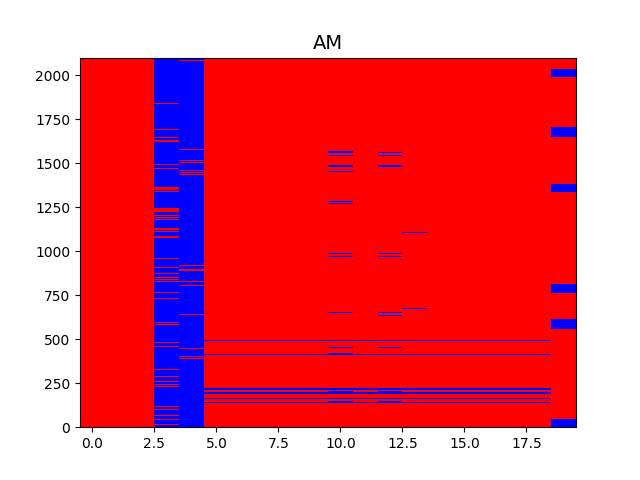

In [56]:
# grafico da base de dados
cmap = colors.ListedColormap(['blue', 'red'])
fig, axes = plt.subplots(nrows=1)
axes.set_title("AM", fontsize=14)
axes.axis([-0.5, 19.5, 0, 2100])
dados = data_set.iloc[:,:].values
# print (dados)
def t(x):
    def z(s):
#         print (s)
        return 0 if (s==0) else 1
#     print (x)
    return list(map(z, x))
dados = list(map(t, dados))
print (len(dados))
# for linha in dados:
#     l = []
#     for celula in linha[:-1]:
#         if celula == 0 or celula == None:
#             l.append(1)
#         else:
#             l.append(0)
#     if linha[-1] != 0 and linha[-1] != None:
#         l.append(0)
#     else:
#         l.append(1)
#     dadosPlot.append(tuple(l))
img = plt.imshow(dados, cmap=cmap, interpolation='nearest', aspect='auto')
plt.show()